(X shape, y shape, every X's mean, every X's standard deviation)
(553, 30, 84) (60, 1) 0.6000094 0.17044733

The dataset has not been preprocessed, is not normalised etc
Iter #16:  Learning rate = 0.000100:  Batch Loss = 18.724197, Accuracy = 0.3125
PERFORMANCE ON TEST SET:          Batch Loss = 18.793787002563477, Accuracy = 0.25
Iter #320:  Learning rate = 0.000100:  Batch Loss = 17.912468, Accuracy = 0.4375
PERFORMANCE ON TEST SET:          Batch Loss = 17.92675018310547, Accuracy = 0.4000000059604645
Iter #640:  Learning rate = 0.000100:  Batch Loss = 17.534573, Accuracy = 0.75
PERFORMANCE ON TEST SET:          Batch Loss = 17.50627899169922, Accuracy = 0.7333333492279053
Iter #960:  Learning rate = 0.000100:  Batch Loss = 17.349821, Accuracy = 0.625
PERFORMANCE ON TEST SET:          Batch Loss = 17.290063858032227, Accuracy = 0.6166666746139526
Iter #1280:  Learning rate = 0.000100:  Batch Loss = 17.050915, Accuracy = 0.75
PERFORMANCE ON TEST SET:          Batch Loss = 17.10817337

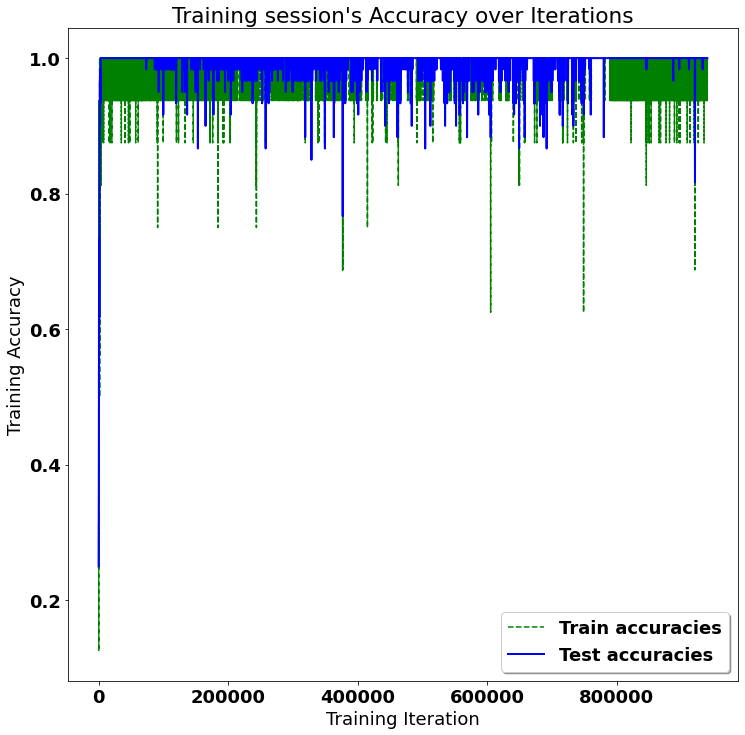

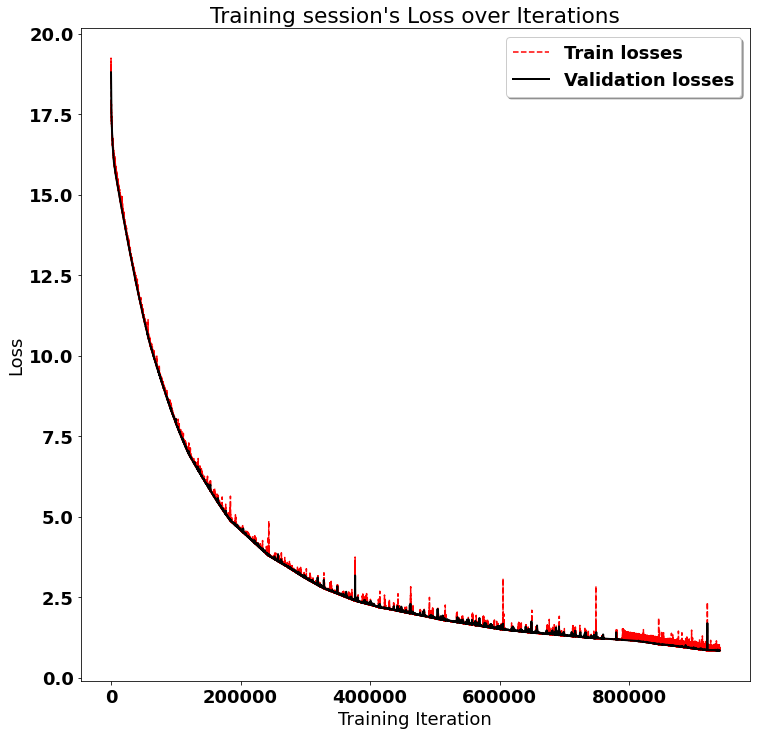


Confusion Matrix:
[[15  0  0  0]
 [ 0 15  0  0]
 [ 0  0 15  0]
 [ 0  0  0 15]]


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
import random
from random import randint
import time
import os
import itertools

# TensorFlow 1.x系のグラフをリセット
tf.reset_default_graph()

# --- 元のコードの大部分はそのまま ---

# Output classes to learn how to classify
LABELS = [
    "ageru",
    "understand",
    "annsinnsuru",
    "heavy"
]

# 学習データのパス
DATASET_PATH = "data/HAR_pose_activities/database/"
X_train_path = os.path.join(DATASET_PATH, "X_train.txt")
X_test_path = os.path.join(DATASET_PATH, "X_test.txt")
y_train_path = os.path.join(DATASET_PATH, "Y_train.txt")
y_test_path = os.path.join(DATASET_PATH, "Y_test.txt")

# ★★★ モデルを保存するディレクトリ ★★★
MODEL_SAVE_PATH = r"C:\\Users\\admin\\Downloads\\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\\weights"
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)


# --- データ読み込み関数 (変更なし) ---
n_steps = 30

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]],
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    X_ = np.array(np.split(X_, blocks))
    return X_

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

# --- モデルのパラメータ設定 (変更なし) ---
training_data_count = len(X_train)
test_data_count = len(X_test)
n_input = len(X_train[0][0])
n_hidden = 34
n_classes = 4
decaying_learning_rate = True
learning_rate = 0.0001
init_learning_rate = 0.0001
decay_rate = 0.96
decay_steps = 100000
global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.01
training_iters = training_data_count * 1700
batch_size = 16
display_iter = batch_size * 20

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")

# --- LSTMモデル定義とバッチ作成関数 (変更なし) ---
def LSTM_RNN(_X, _weights, _biases):
    _X = tf.transpose(_X, [1, 0, 2])
    _X = tf.reshape(_X, [-1, n_input])
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    _X = tf.split(_X, n_steps, 0)
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)
    lstm_last_output = outputs[-1]
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']

def extract_batch_size(_train, _labels, _unsampled, batch_size):
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size, 1))
    for i in range(batch_size):
        index = random.choice(_unsampled)
        batch_s[i] = _train[index]
        batch_labels[i] = _labels[index]
        _unsampled.remove(index)
    return batch_s, batch_labels, _unsampled

def one_hot(y_):
    y_ = y_.reshape(len(y_))
    n_values = n_classes
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]

# --- TensorFlowグラフ構築 (変更なし) ---
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden]), name="weights_hidden"),
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0), name="weights_out")
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden]), name="biases_hidden"),
    'out': tf.Variable(tf.random_normal([n_classes]), name="biases_out")
}
pred = LSTM_RNN(x, weights, biases)
l2 = lambda_loss_amount * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step * batch_size, decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost, global_step=global_step)
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# ★★★ モデル保存のためのSaverオブジェクトを作成 ★★★
saver = tf.train.Saver()


# --- Plotting additions start ---
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
# --- Plotting additions end ---

# --- 学習セッション ---
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=False))
init = tf.global_variables_initializer()
sess.run(init)

step = 1
time_start = time.time()
unsampled_indices = list(range(0, len(X_train)))

while step * batch_size <= training_iters:
    if len(unsampled_indices) < batch_size:
        unsampled_indices = list(range(0, len(X_train)))
    batch_xs, raw_labels, unsampled_indices = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0], :batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
    
    _, loss, acc = sess.run([optimizer, cost, accuracy], feed_dict={x: batch_xs, y: batch_ys})
    
    # --- Plotting additions start ---
    train_losses.append(loss)
    train_accuracies.append(acc)
    # --- Plotting additions end ---

    if (step * batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        print("Iter #" + str(step * batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":  Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        loss_test, acc_test = sess.run([cost, accuracy], feed_dict={x: X_test, y: one_hot(y_test)})
        
        # --- Plotting additions start ---
        test_losses.append(loss_test)
        test_accuracies.append(acc_test)
        # --- Plotting additions end ---

        print("PERFORMANCE ON TEST SET:          " + \
              "Batch Loss = {}".format(loss_test) + \
              ", Accuracy = {}".format(acc_test))

    step += 1

print("Optimization Finished!")
time_stop = time.time()
print("TOTAL TRAINING TIME: {}".format(time_stop - time_start))

# ★★★ 学習が完了したモデルを保存 ★★★
save_path = saver.save(sess, os.path.join(MODEL_SAVE_PATH, "model.ckpt"))
print(f"Model saved in path: {save_path}")


# --- 学習直後のテストデータでの最終評価 (これはtrain.pyに残しても良い) ---
print("\n--- Final Evaluation on Test Set (after training) ---")
one_hot_predictions, final_accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(final_accuracy))

# --- Plotting additions start ---
font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')
plt.show()

# Lossのプロット
plt.figure(figsize=(width, height))
plt.plot(indep_train_axis, np.array(train_losses), "r--", label="Train losses")
plt.plot(indep_test_axis, np.array(test_losses), "k-", linewidth=2.0, label="Validation losses")
plt.title("Training session's Loss over Iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Loss')
plt.xlabel('Training Iteration')
plt.show()
# --- Plotting additions end ---

# 混同行列の表示
predictions = one_hot_predictions.argmax(1)
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

print("\nConfusion Matrix:")
print(confusion_matrix)

sess.close()